# Anomaly detection in faces using VQ-VAE

**Show necessary code blocks to reproduce some examples. Some reconstructions, evalutation scores etc.**

This notebook is in addition to the blogpost a tool to guide you through the research we performed inspired on the work of Marimont et al. on Anomaly detection through latent space restoration using VQ-VAE [1]. The purpose of this notebook is not to explain all the theoretical components of the research, rather it is to provide a step-by-step guide to obtain results on a toy data set in the form of snippets of code in conjunction with explanatory text. This is done with the intention to deliver a greater understanding of the topic covered.
The structure of this notebook is as follows:
1.   go over the necessary pre requisites needed to understand the project. 
2.   Delve deeper into the components of the original work showing snippets of code that are relevant.
3. Introduce the setup of the faces datasets.
4. Briefly go over pre-processing changes and relevant code.
5. Highlight the changes that are necessary to adapt the original models to fit the new context.
6. Touch upon the metrics used for evaluating and showing a summary of quantitative and qualitative results.

**Abstract**
(...)

# 1. Pre-requisites

In this section we are going to present some of the fundamental components to have a better understanding of the proposed methodology. This means we will cover the VQ-VAE and the PixelSnail. Additionally, we will cover the structure of the data, this will be necessary to understand the changes made later.


## Imports

In [2]:
import torch
import torchvision.transforms as transforms
import numpy as np
from torch.utils.data import DataLoader
import torch.nn.functional as F
from torchvision.datasets import ImageFolder
from tqdm import tqdm
import matplotlib.pyplot as plt
import nets_LV
import nets_AR
import utils


/home/lcur1737/.conda/envs/vae/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: martentyrk (vqvaeanomaly). Use `wandb login --relogin` to force relogin


# Fake and real faces demo

## Initialize models with pretrained weights

In [3]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

vqvae_checkpoint_path = '/home/lcur1737/checkpoints/ffhq_continued_020.pt'
ar_checkpoint_path = '/home/lcur1737/checkpoints/ffhq_ar_030.pt'
vqvae_checkpoint = torch.load(vqvae_checkpoint_path, map_location=device)
ar_checkpoint = torch.load(ar_checkpoint_path, map_location=device)

vq_model = nets_LV.VQVAE(
    d=3,
    n_channels=(16, 32, 64, 256),
    code_size=128,
    n_res_block=2,
    dropout_p=.1
).to(device)

vq_model.load_state_dict(vqvae_checkpoint["model"])
vq_model = vq_model.to(device)

ar_model = nets_LV.VQLatentSNAIL(
    feature_extractor_model=vq_model,
    shape=(16, 16),
    n_block=4,
    n_res_block=4,
    n_channels=128
).to(device)

ar_model.load_state_dict(ar_checkpoint['model'])
ar_model = ar_model.to(device)

## FFHQ 512 & Real/Fake faces dataset

In [4]:
transform_pipeline = transforms.Compose([
    transforms.ToTensor()
])

demo_data_path_ffhq = '/home/lcur1737/AnomalyDetection/data/FFhq_toy'


demo_dataset = ImageFolder(demo_data_path_ffhq, transform=transform_pipeline)
demo_dataloader = DataLoader(demo_dataset, batch_size=3, shuffle=True)

## Sample wise score

In [5]:
threshold = 7

pred = []

ar_model.eval()
for X, _ in tqdm(demo_dataloader):
    with torch.no_grad():
        X=X.to(device)
        loss = ar_model.loss(X, reduction='none')['loss'].flatten(1)
        
        score = torch.sum(loss*(loss>threshold), 1).float()
        pred.append(score.cpu().numpy())

100%|██████████| 1/1 [00:01<00:00,  1.77s/it]


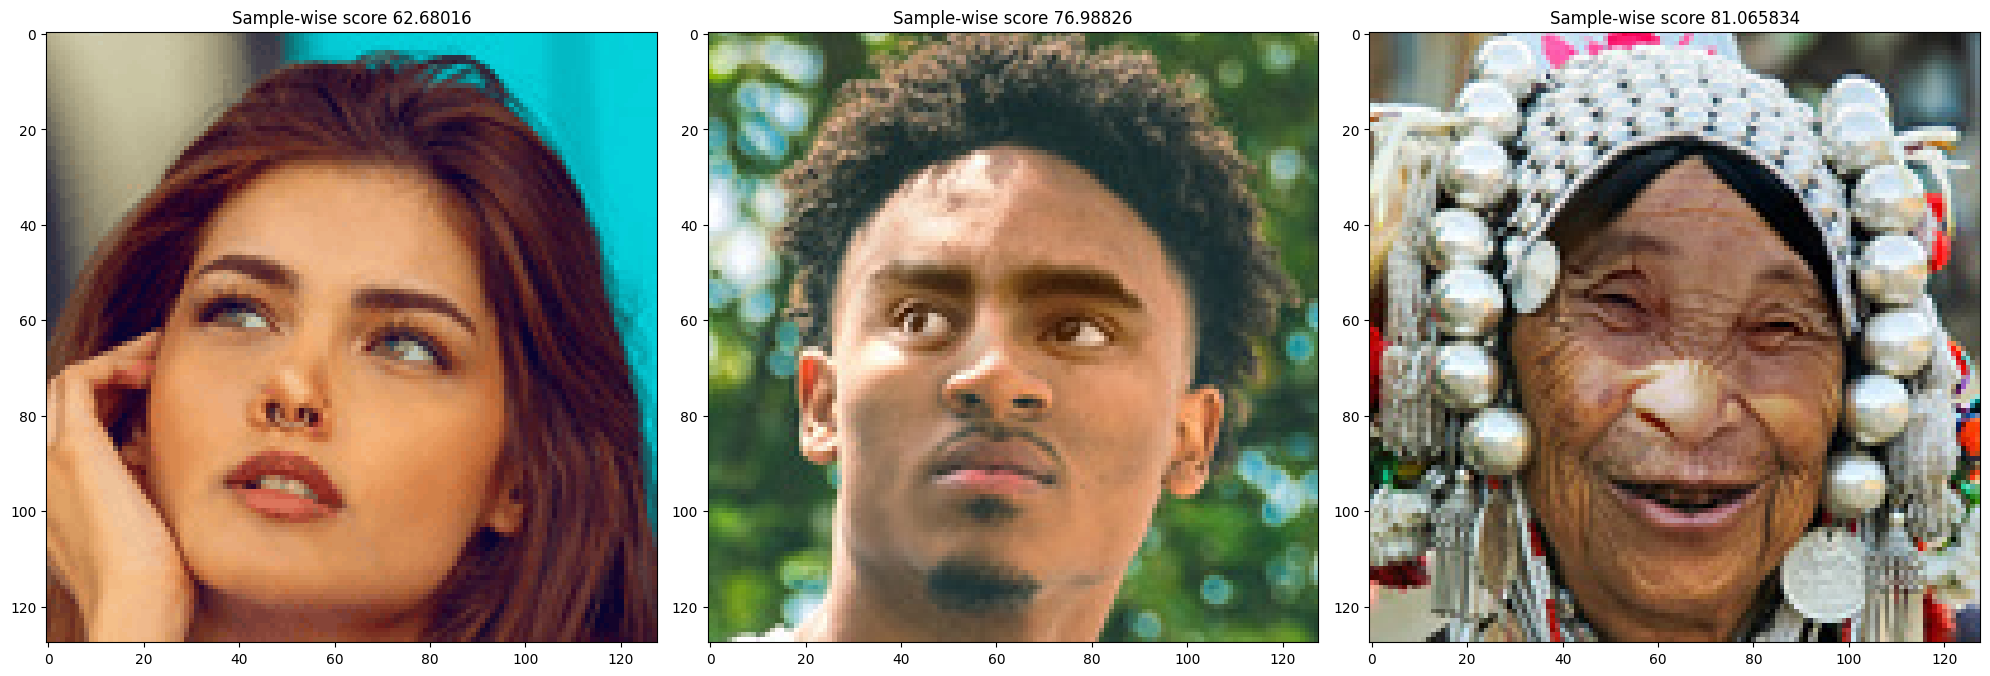

In [6]:
X = next(iter(demo_dataloader))[0]
fix, axes = plt.subplots(1,3, figsize=(20,10))
axes[0].imshow(X[0].permute(1,2,0))
axes[0].set_title('Sample-wise score '+ str(pred[0][0]))
axes[1].imshow(X[1].permute(1,2,0))
axes[1].set_title('Sample-wise score '+ str(pred[0][1]))
axes[2].imshow(X[2].permute(1,2,0))
axes[2].set_title('Sample-wise score '+ str(pred[0][2]))

plt.tight_layout()
plt.show()

## Reconstructing with pixel-score

In [9]:
def reconstruct(n, img, threshold_log_p = 5):
    """ Generates n reconstructions for each image in img.
    Resamples latent variables with cross-entropy > threshold
    Returns corrected images and associated latent variables"""
          
    #Use VQ-VAE to encode original image
    codes = ar_model.retrieve_codes(img)
    code_size = codes.shape[-2:]

    with torch.no_grad():
        samples = codes.clone().unsqueeze(1).repeat(1,n,1,1).reshape(img.shape[0]*n,*code_size)

        if not threshold_log_p == None:
            for r in tqdm(range(code_size[0])):
                for c in range(code_size[1]):        

                    code_logits = ar_model.forward_latent(samples)[:,:,r,c]
                    loss = F.cross_entropy(code_logits, samples[:, r, c], reduction='none')
                    probs = F.softmax(code_logits, dim=1)

                    samples[loss > threshold_log_p, r, c] = torch.multinomial(probs, 1).squeeze(-1)[loss > threshold_log_p]

        z = vq_model.codebook.embedding(samples.unsqueeze(1))
        z = z.squeeze(1).permute(0,3,1,2).contiguous()
        
        # Split the calculation in batches
        x_tilde = []
        for i in range(img.shape[0]):
            x_tilde.append(vq_model.decode(z[i*n:(i+1)*n]))
        x_tilde = torch.cat(x_tilde)
        
        
    return x_tilde.reshape(img.shape[0]*img.shape[1],n,*img.shape[-2:]), samples.reshape(img.shape[0],n,*code_size)


In [18]:
reconstructions = []
for X in next(iter(demo_dataloader)):
    X = torch.Tensor(X).to(device)
    
    reconstructions.append(reconstruct(n=5,img=X, threshold_log_p=8)[0])
    


100%|██████████| 16/16 [00:07<00:00,  2.13it/s]


RuntimeError: Input type (long int) and bias type (float) should be the same

# FaceForensics ++ demo

## Initialize models with pretrained weights

In [ ]:
vqvae_checkpoint_path = 'demo_checkpoints/faceforensics_vqvae.pt'
vqvae_checkpoint = torch.load(vqvae_checkpoint_path, map_location=device)

ar_checkpoint_path = 'demo_checkpoints/faceforensics_ar.pt'
ar_checkpoint = torch.load(ar_checkpoint_path, map_location=device)

vq_model = nets_LV.VQVAE(
    d=3,
    n_channels=(16, 32, 64, 256),
    code_size=128,
    n_res_block=2,
    dropout_p=.1
).to(device)

vq_model.load_state_dict(vqvae_checkpoint["model"])
vq_model = vq_model.to(device)

ar_model = nets_LV.VQLatentSNAIL(
    feature_extractor_model=vq_model,
    shape=(16, 16),
    n_block=4,
    n_res_block=4,
    n_channels=128
).to(device)

ar_model.load_state_dict(ar_checkpoint['model'])
ar_model = ar_model.to(device)

## FaceForensics++

In [ ]:
transform_pipeline = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

demo_data_path_ffhq = 'demo_data/faceforensics'

demo_dataset = ImageFolder(demo_data_path_ffhq, transform=transform_pipeline)
demo_dataloader = DataLoader(demo_dataset, batch_size=1, shuffle=True)

# 4. Pre-processing pipeline

# 5. Modifications original methodology

# 6. Evaluation and discussion